**Introduccion al problema**.

En este proyecto, se busca que por medio de la optimizacion se estime los parametros asociados entre la velocidad del viento y la potencia que genera una turbina eolica, teniendo en cuenta los valores de la tabla. También se busca analizar el problema con sus datos para llegar a una o multiples respuestas posibles, siempre y cuando se encuentre la mejor optimizada.



In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import jacfwd, jacrev
from jax import random
import matplotlib.pyplot as plt

def funpot(velocidad, coeficientes): #Se calcula el polinomio de la forma P(v,alfa)
    num_coef = len(coeficientes)#calculo de coeficientes (° del polinomio)
    valores = [coeficientes[i] * jnp.power(velocidad, i) for i in range(num_coef)]# se calcula cada termino del polinomio (ai*v**i)
    return jnp.sum(jnp.stack(valores, axis=-1), axis=-1)# sum(Ai*v**i)

def funobj(alfa, velocidad, potencia): #Se define la función objetivo como se plantea en el documento
    valores_pot = funpot(velocidad, alfa)#potencia estimada, en funcion de v,alfa
    difpot = potencia - valores_pot# diferencia de potencias
    return jnp.sum(jnp.square(difpot))# sumatoria de diferencias al cuadrado

grad_funobj = jax.grad(funobj)

def minHessian(alfa, velocidad, potencia):
    Hessian = jacfwd(jacrev(funobj))(alfa, velocidad, potencia)
    gradient = grad_funobj(alfa, velocidad, potencia)
    delta_alfa = jnp.linalg.solve(Hessian, gradient)
    nuevo_alfa = alfa - delta_alfa
    return nuevo_alfa

Se contienen una serie de valores de velocidad y potencia en un array, donde cada uno representa una medicion. estos datos se utilizaran para encontrar un conjunto de coeficientes alfa.


In [ ]:
#Valores de la tabla
velocidad = jnp.array([0.126,0.799,1.287,1.749,2.259,2.719,3.284,3.751,4.246,4.745,5.244,5.724,6.324,6.738,7.238,7.728,8.232,8.741,9.219,9.704,10.230,10.724,11.211,11.767,12.245,12.715,13.226,13.743,14.300,14.696,15.232,15.649,16.029,16.803,17.049,17.885])
potencia = jnp.array([-3.151,-3.181,-3.213,-3.187,2.824,20.331,74.153,132.315,225.115,347.751,486.502,660.094,838.259,1039.989,1229.457,1411.141,1540.810,1681.272,1783.571,1818.255,1822.494,1821.436,1838.905,1840.394,1838.213,1839.370,1838.915,1839.852,1840.354,1840.536,1840.206,1840.670,1839.220,1838.905,1829.330,1837.585])


In [ ]:
num_componentes = 9 #Se asume que el polinomio es de orden 9

# Listas para almacenar los resultados
soluciones = []  # Almacena los vectores solucion
curvas_objetivo = []  # Almacena la curvas de función objetivo vs iteraciones

# Realiza el proceso de optimización 50 veces
num_realizaciones = 50
for realizacion in range(num_realizaciones):
    # Generar una nueva semilla aleatoria como se vió en la clase
    key = random.PRNGKey(realizacion)

    # Generar un alfa inicial aleatorio dentro del rango definido
    alfa_inicial = random.uniform(key, minval=0.3, maxval=0.6, shape=(num_componentes,))

    alfa_realizacion = alfa_inicial.copy()  # Copia la estimación inicial para cada realización

    # Listas para almacenar resultados por realización
    objetivo_por_iteracion = []  # Almacenará los valores de función objetivo en cada iteración

    # Proceso de optimización
    for epoch in range(50):
        alfa_realizacion = minHessian(alfa_realizacion, velocidad, potencia)
        objetivo_actual = funobj(alfa_realizacion, velocidad, potencia)
        objetivo_por_iteracion.append(objetivo_actual)

    # Almacena los resultados de esta realización
    soluciones.append(alfa_realizacion)
    curvas_objetivo.append(objetivo_por_iteracion)




Una vez se cumpla el bucle de las las 50 realizacion, soluciones y curva_objeto tendran los resultados de la optimizacion para cada realizacion. donde soluciones dendra los vectores alfa y curva_objeto tendra las curvas de la fucion objeto alo largo de las iteraciones


In [ ]:
# Convierte las listas en arreglos jnp
soluciones_array = jnp.array(soluciones)
curvas_objetivo_array = jnp.array(curvas_objetivo)


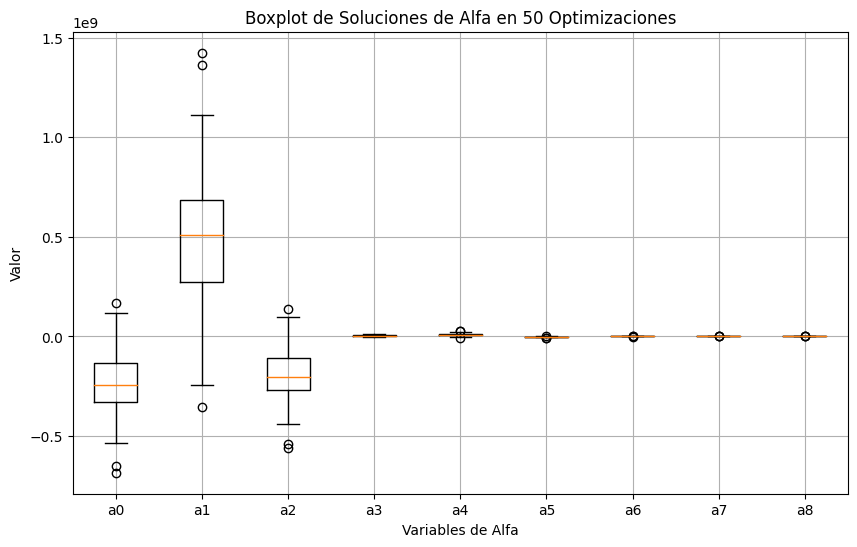

In [ ]:
# Boxplot de las soluciones encontradas en cada optimización
plt.figure(figsize=(10, 6))
plt.boxplot(soluciones_array.T)
plt.xlabel('Variables de Alfa')
plt.ylabel('Valor')
plt.title('Boxplot de Soluciones de Alfa en 50 Optimizaciones')
plt.xticks(range(1, soluciones_array.shape[1] + 1), [f'a{i}' for i in range(0, soluciones_array.shape[1] )])
plt.grid(True)
plt.show()

Según se puede apreciar de la gráfica, el alfa a partir del exponente 4 en adelante es aproximadamente cero según el boxplot, por lo que correspondiente a lo que dice el documento, se puede aproximar con 4 parámetros la función que se tiene

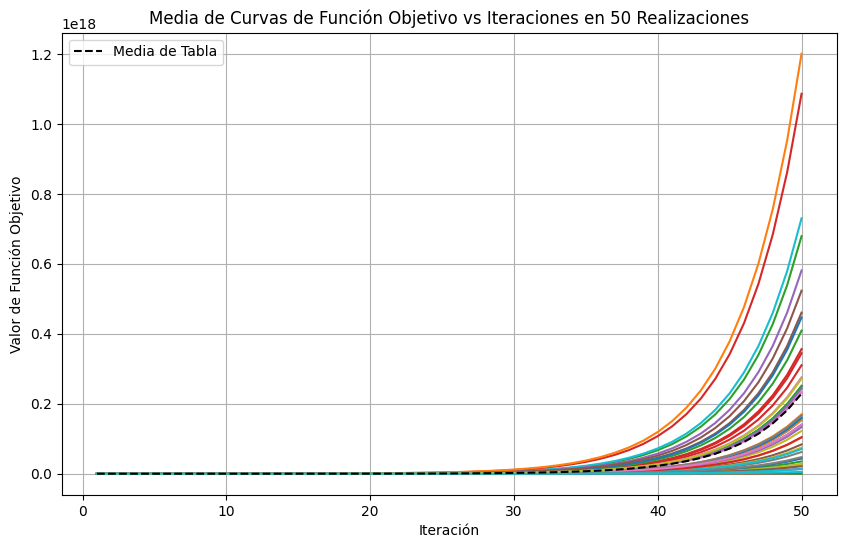

In [ ]:
# Grafica la media de las curvas de función objetivo vs iteraciones

media_tabla = jnp.mean(curvas_objetivo_array, axis=0)
plt.figure(figsize=(10, 6))
for i in range(curvas_objetivo_array.shape[0]):
    plt.plot(range(1, len(curvas_objetivo_array[i]) + 1), curvas_objetivo_array[i])
plt.plot(range(1, len(media_tabla) + 1), media_tabla, label='Media de Tabla', linestyle='--', color='black')
plt.xlabel('Iteración')
plt.ylabel('Valor de Función Objetivo')
plt.title('Media de Curvas de Función Objetivo vs Iteraciones en 50 Realizaciones')
plt.legend()
plt.grid(True)
plt.show()

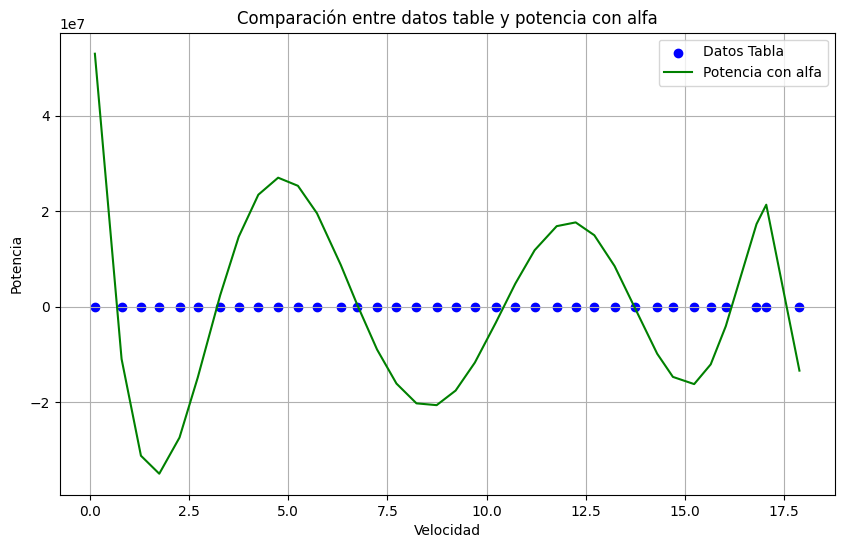

In [ ]:
alfa_minimos = alfa_realizacion  # Usar los alfa obtenidos en la optimización
potencia_predicha = funpot(velocidad, alfa_minimos)

# Graficar los datos originales y la función de potencia predicha
plt.figure(figsize=(10, 6))
plt.scatter(velocidad, potencia, label='Datos Tabla', color='blue', marker='o')
plt.plot(velocidad, potencia_predicha, label='Potencia con alfa', color='green')
plt.xlabel('Velocidad')
plt.ylabel('Potencia')
plt.title('Comparación entre datos table y potencia con alfa')
plt.legend()
plt.grid(True)
plt.show()

**Concluciones**


 -El numero de realizaciones es util para mitigar el riesgo de quedar atrapado en mínimos locales. Al repetir la optimización con diferentes condiciones iniciales, es más probable que se encuentre un mínimo global o una solución de mejor calidad.


-Los gráficos generados permiten una mejor comprensión de los resultados de optimización. El boxplot de las soluciones optimizadas muestra la variabilidad en los coeficientes alfa obtenidos, mientras que la gráfica de la función objetivo promedio a lo largo de las iteraciones proporciona información sobre la convergencia y la estabilidad del proceso de optimización.

-La elección de parámetros iniciales para los coeficientes alfa es crítica para el éxito de la optimización. Al generar valores iniciales aleatorios dentro de un rango definido, se exploran diferentes regiones del espacio de búsqueda, lo que puede ayudar a encontrar soluciones mejores.


-La función objetivo juega un papel en este caso,donde se busca minimizar la diferencia entre los valores predichos y reales de potencia. A medida que la optimización progresa, los valores de la función objetivo deberían disminuir, lo que indica que el ajuste del polinomio se está acercando a los datos reales.



-Si bien los resultados son prometedores, es importante validar el ajuste del polinomio y las soluciones obtenidas.

Según la gráfica aproximadamente con 14 repeticiones es suficiente para ejecutar el proceso de optimización